In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

In [49]:
#using kaggle api

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"saketgarodia1","key":"c9d81a17bfe47308e791885989ee4844"}'}

In [50]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
#searching for the dataset

#Search for datasets and competitions by name
!kaggle datasets list -s fruits

Let us download the data into the drive.

In [53]:
!kaggle datasets download -d moltean/fruits -p /content/gdrive/My\ Drive/kaggle --force

100% 734M/734M [00:04<00:00, 175MB/s]
100% 734M/734M [00:04<00:00, 155MB/s]


In [12]:
!ls "/content/gdrive/My Drive/kaggle"


Test.zip  Training.zip


Now that we have downloaded the dataset, let us unzip the training and test set.

In [ ]:
#unzipping training folder

!unzip -uq "/content/gdrive/My Drive/kaggle/Training.zip" -d "/content/gdrive/My Drive/kaggle"

In [ ]:
#unzipping test folder

!unzip -uq "/content/gdrive/My Drive/kaggle/Test.zip" -d "/content/gdrive/My Drive/kaggle"

In [ ]:
#import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [ ]:
# Loading data and putting them into training and test sets

#locations setting for training and test datasets
train_data='/content/gdrive/My Drive/kaggle/Training'
test_data='/content/gdrive/My Drive/kaggle/Test'

#creates X_train and Y_train using file_names and folders
def get_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

X_train, Y_train, labels = get_data(train_data)
X_test, Y_test,_ = get_data(test_data)

In [ ]:
Y_train = np_utils.to_categorical(Y_train, 120)
Y_test = np_utils.to_categorical(Y_test, 120)

In [ ]:
# splitting train set into training and validation sets

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=33)
Y_train, Y_val = train_test_split(Y_train, test_size=0.2, random_state=33)

In [19]:
#sanity check for shape

X_val.shape

(12100,)

In [ ]:
#converting images into array to start computation

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

X_train = np.array(convert_image_to_array(X_train))
X_val = np.array(convert_image_to_array(X_val))
X_test = np.array(convert_image_to_array(X_test))

We will normalize our inputs y using division by 255 since 255 is the maximum possible pixel values. Normalizing inputs helps neural networks run faster else it goes around like a ball in a bowl.

In [ ]:
#nomalizing the pixel values before feeding into a neural network

X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [22]:
#Building model 1 using customized convolutional and pooling layers

model = Sequential()

#input_shape is 100*100 since thats the dimension of each of the fruit images
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

# specifying parameters for fully connected layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(120,activation = 'softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      208       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        8256      


In order to speed up our training, we will use **Adam optimizer** instead of Stochastic Gradient descent. Adam takes the advantage of both the momentum and rmsprop by leading us fast to the optimized values.

In [ ]:
#importing ootimizers

from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Its time to fit our model. We will use a **batch size of 128** and check for **20 epochs**.

In [30]:
# creating a file to save the trained CNN model 
checkpointer = ModelCheckpoint(filepath = 'cnn_from_scratch_fruits.hdf5', verbose = 1, save_best_only = True)

# fitting model using above defined layers 
CNN_model = model.fit(X_train,Y_train,
        batch_size = 128,
        epochs=20,
        validation_data=(X_val, Y_val),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Train on 48398 samples, validate on 12100 samples
Epoch 1/20
 - 9s - loss: 0.0270 - acc: 0.9909 - val_loss: 2.6987e-04 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00027, saving model to cnn_from_scratch_fruits.hdf5
Epoch 2/20
 - 9s - loss: 0.0272 - acc: 0.9907 - val_loss: 9.5851e-04 - val_acc: 0.9998

Epoch 00002: val_loss did not improve from 0.00027
Epoch 3/20
 - 9s - loss: 0.0306 - acc: 0.9894 - val_loss: 2.3071e-04 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00027 to 0.00023, saving model to cnn_from_scratch_fruits.hdf5
Epoch 4/20
 - 9s - loss: 0.0257 - acc: 0.9914 - val_loss: 0.0018 - val_acc: 0.9991

Epoch 00004: val_loss did not improve from 0.00023
Epoch 5/20
 - 9s - loss: 0.0225 - acc: 0.9922 - val_loss: 5.4797e-04 - val_acc: 0.9998

Epoch 00005: val_loss did not improve from 0.00023
Epoch 6/20
 - 10s - loss: 0.0276 - acc: 0.9909 - val_loss: 1.8326e-04 - val_acc: 0.9999

Epoch 00006: val_loss improved from 0.00023 to 0.00018, saving model to cn

In [ ]:
#loading saved weights to use further

model.load_weights('cnn_from_scratch_fruits.hdf5')


Lets check the score of our model in the test set.

In [32]:
#checking testset accuracy

score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

20622/20622 [==============================] - 3s 137us/step
Test accuracy: 0.9941324798758607


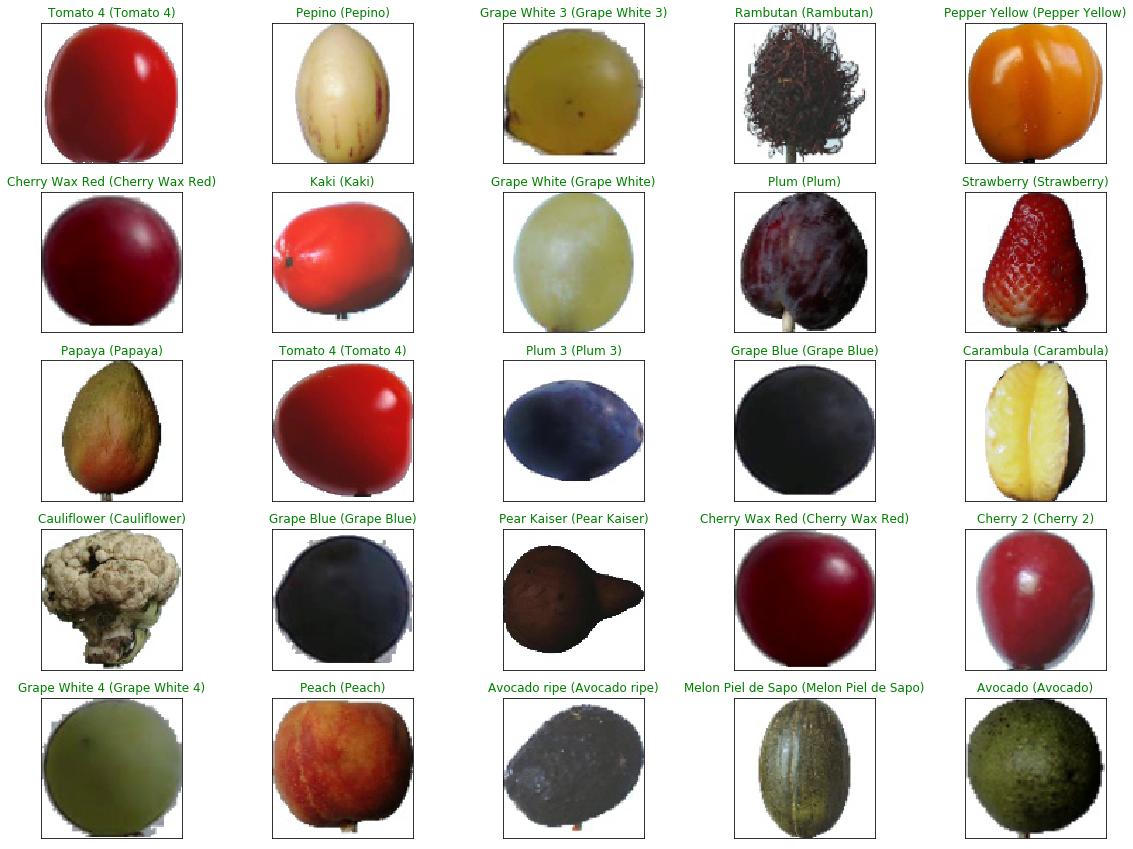

In [33]:
# using model to predict on test data
Y_pred = model.predict(X_test)

# Lets plot the predictions of different fruits and check their original labels

fig = plt.figure(figsize=(20, 15))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(Y_pred[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

Now, let us see how the loss function an accuracy changes as the model trains for 20 epochs

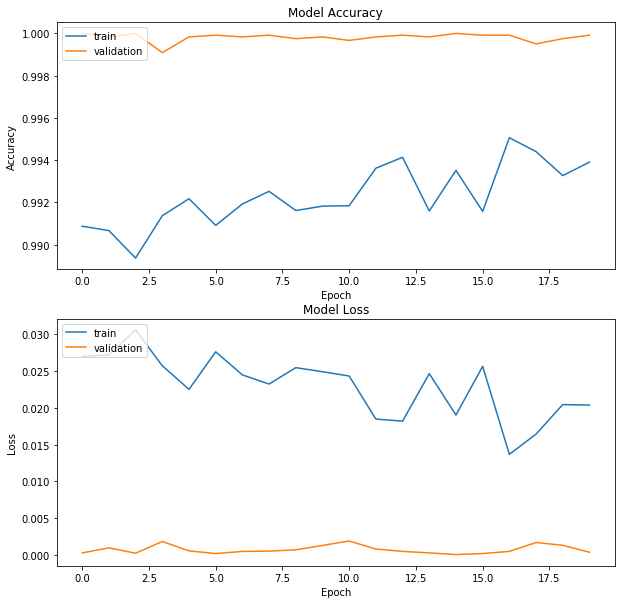

In [34]:
#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(CNN_model.history['acc'])  
plt.plot(CNN_model.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(CNN_model.history['loss'])  
plt.plot(CNN_model.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

In [35]:
#importing vgg16

#Part 2 using transfer learning

#importing vgg16 architecture which is trained on Imagenet

from keras.applications.vgg16 import VGG16

vgg_model = VGG16(input_shape=[100,100,3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


We will freeze our base layer as we only want to train the layers which we are gonna add later.

In [ ]:
#We will not train the layers imported.

for layer in vgg_model.layers:
   layer.trainable = False

In [37]:
#summary of the imported vgg model

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [40]:
#adding some layers to the vgg_model imported and again fitting the model to check the performance

transfer_learning_model = Sequential()
 
transfer_learning_model.add(vgg_model)


transfer_learning_model.add(Conv2D(1024, kernel_size=3, padding='same'))

transfer_learning_model.add(Activation('relu'))

transfer_learning_model.add(MaxPooling2D(pool_size=(2, 2)))
transfer_learning_model.add(Dropout(0.3))

transfer_learning_model.add(Flatten())
transfer_learning_model.add(Dense(150))
transfer_learning_model.add(Activation('relu'))
transfer_learning_model.add(Dropout(0.4))
transfer_learning_model.add(Dense(120,activation = 'softmax'))
transfer_learning_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 1024)        4719616   
_________________________________________________________________
activation_3 (Activation)    (None, 3, 3, 1024)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)              

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
transfer_learning_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [43]:
#fitting the new model


checkpointer = ModelCheckpoint(filepath = 'transfer_learning.hdf5', verbose = 1, save_best_only = True)

# running 
transfer_learning_cnn = transfer_learning_model.fit(X_train,Y_train,
        batch_size = 128,
        epochs=20,
        validation_data=(X_val, Y_val),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Train on 48398 samples, validate on 12100 samples
Epoch 1/20
 - 37s - loss: 1.6858 - acc: 0.5888 - val_loss: 0.1418 - val_acc: 0.9736

Epoch 00001: val_loss improved from inf to 0.14179, saving model to transfer_learning.hdf5
Epoch 2/20
 - 35s - loss: 0.2364 - acc: 0.9316 - val_loss: 0.0298 - val_acc: 0.9956

Epoch 00002: val_loss improved from 0.14179 to 0.02981, saving model to transfer_learning.hdf5
Epoch 3/20
 - 35s - loss: 0.1154 - acc: 0.9663 - val_loss: 0.0105 - val_acc: 0.9984

Epoch 00003: val_loss improved from 0.02981 to 0.01047, saving model to transfer_learning.hdf5
Epoch 4/20
 - 35s - loss: 0.0682 - acc: 0.9793 - val_loss: 0.0030 - val_acc: 0.9998

Epoch 00004: val_loss improved from 0.01047 to 0.00295, saving model to transfer_learning.hdf5
Epoch 5/20
 - 35s - loss: 0.0567 - acc: 0.9830 - val_loss: 0.0026 - val_acc: 0.9997

Epoch 00005: val_loss improved from 0.00295 to 0.00259, saving model to transfer_learning.hdf5
Epoch 6/20
 - 35s - loss: 0.0527 - acc: 0.9832 - val_l

In [ ]:
transfer_learning_model.load_weights('transfer_learning.hdf5')


In [45]:
#score of the new model built using transfer learning

score = transfer_learning_model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

20622/20622 [==============================] - 14s 670us/step
Test accuracy: 0.9765299194861009


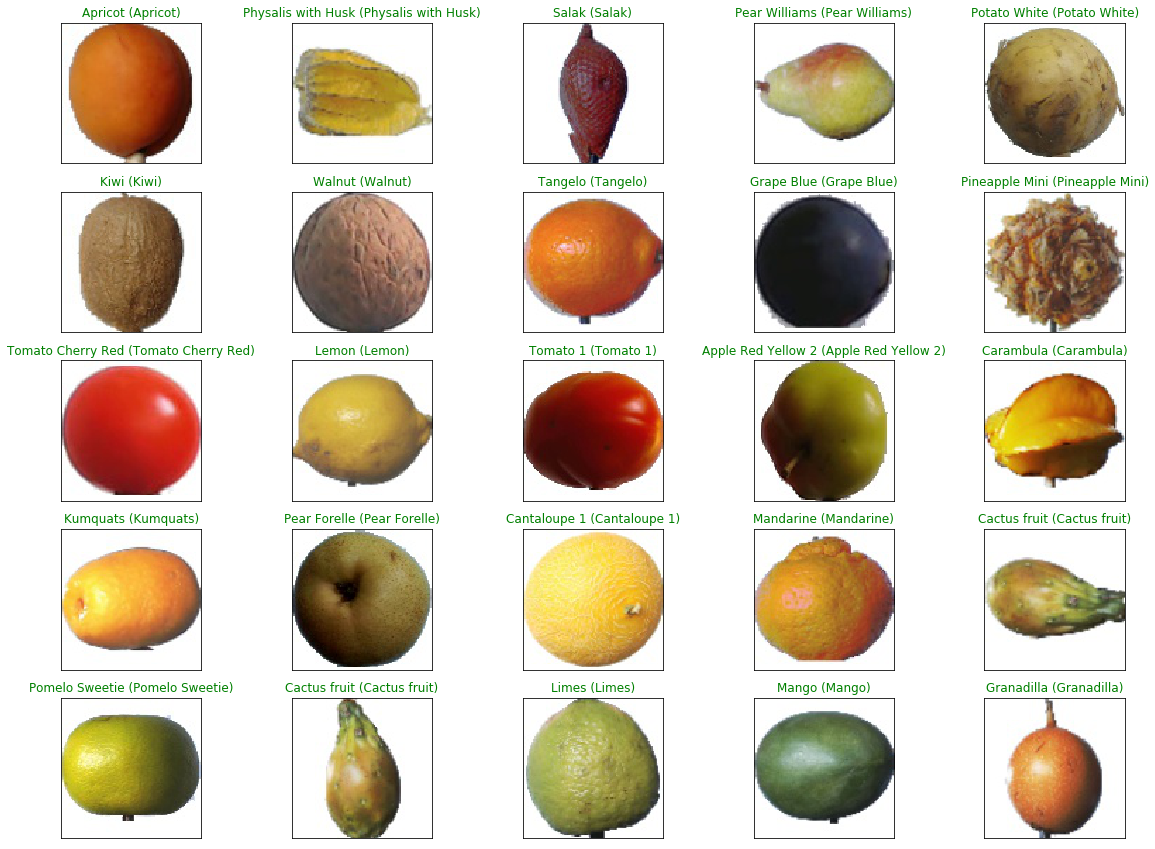

In [46]:
# using model to predict on test data
Y_pred = transfer_learning_model.predict(X_test)

fig = plt.figure(figsize=(20, 15))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(Y_pred[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

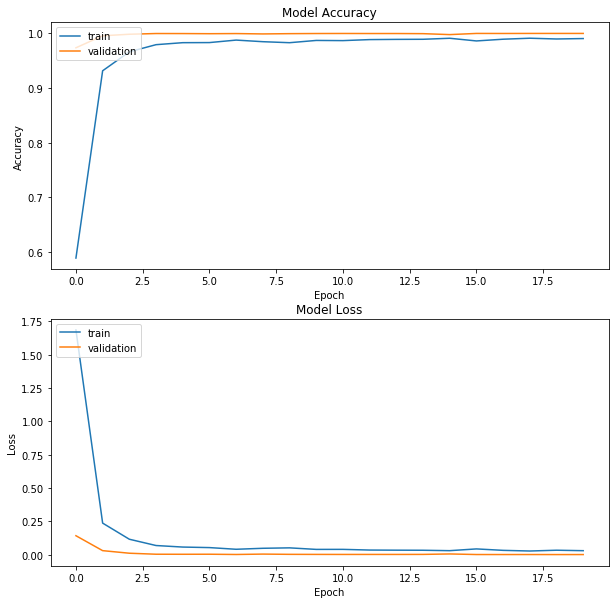

In [47]:
#plotting curves for the transfer learning model

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(transfer_learning_cnn.history['acc'])  
plt.plot(transfer_learning_cnn.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(transfer_learning_cnn.history['loss'])  
plt.plot(transfer_learning_cnn.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()